### **Requirements**

In [ ]:
pip install ydata_profiling catboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=f0dcf62c04f233abbba7974fe296027ed33399d91fbcd57b836bb939bcfb5ba5
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


# **Ensemble methods**

In this notebook I will present an ensemble method for solving a classification problem. I will use decision trees as the basic algorithm

---

## **Libraries**

In [ ]:
import kagglehub
import os
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

---

## **Dataset**

**Context**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Attribute Information**

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
os.listdir(path)

['heart.csv']

In [ ]:
data = pd.read_csv(os.path.join(path, os.listdir(path)[0]))
new_data = data.copy()

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


---

## **Profiling**

In [ ]:
profile = ProfileReport(new_data, title="Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 45.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are no duplicates or missing values ​​in the data. However, there are outliers

*Ideally, the outliers should have been processed, but I did not perform this step*



---

## **Preprocessing**

In [ ]:
columns_number, columns_category = new_data.select_dtypes(include='number').columns, new_data.select_dtypes(exclude='number').columns
columns_number.shape, columns_category.shape

((7,), (5,))

**Additional transformation**

In [ ]:
new_data[columns_category] = new_data[columns_category].astype('category')
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    int64   
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(5), float64(1), int64(6)
memory usage: 55.5 KB


In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
data_encoder = pd.DataFrame(encoder.fit_transform(new_data[columns_category]), columns=encoder.get_feature_names_out())

In [ ]:
new_data = pd.concat((new_data[columns_number], data_encoder), axis=1)
new_data

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0     40        140          289          0    172      0.0             0   
1     49        160          180          0    156      1.0             1   
2     37        130          283          0     98      0.0             0   
3     48        138          214          0    108      1.5             1   
4     54        150          195          0    122      0.0             0   
..   ...        ...          ...        ...    ...      ...           ...   
913   45        110          264          0    132      1.2             1   
914   68        144          193          1    141      3.4             1   
915   57        130          131          0    115      1.2             1   
916   57        130          236          0    174      0.0             1   
917   38        138          175          0    173      0.0             0   

     Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0      1.0                1.0                0.0               0.0   
1      0.0                0.0                1.0               0.0   
2      1.0                1.0                0.0               0.0   
3      0.0                0.0                0.0               0.0   
4      1.0                0.0                1.0               0.0   
..     ...                ...                ...               ...   
913    1.0                0.0                0.0               1.0   
914    1.0                0.0                0.0               0.0   
915    1.0                0.0                0.0               0.0   
916    0.0                1.0                0.0               0.0   
917    1.0                0.0                1.0               0.0   

     RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0                  1.0            0.0               0.0            0.0   
1                  1.0            0.0               0.0            1.0   
2                  0.0            1.0               0.0            0.0   
3                  1.0            0.0               1.0            1.0   
4                  1.0            0.0               0.0            0.0   
..                 ...            ...               ...            ...   
913                1.0            0.0               0.0            1.0   
914                1.0            0.0               0.0            1.0   
915                1.0            0.0               1.0            1.0   
916                0.0            0.0               0.0            1.0   
917                1.0            0.0               0.0            0.0   

     ST_Slope_Up  
0            1.0  
1            0.0  
2            1.0  
3            0.0  
4            1.0  
..           ...  
913          0.0  
914          0.0  
915          0.0  
916          0.0  
917          1.0  

[918 rows x 16 columns]

In [ ]:
X, y = new_data.drop('HeartDisease', axis=1), new_data['HeartDisease']
X.shape, y.shape

((918, 15), (918,))

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=.85, stratify=y)
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((780, 15), (138, 15), (780,), (138,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=.85, stratify=y_train_val)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((663, 15), (117, 15), (663,), (117,))

---

## **Methods**

### **Bagging**

Bagging trains n models on different bootstrapped samples of the dataset. The models are treated as independent, since each is trained on a unique subset created by sampling with replacement

In [ ]:
base_estimator = DecisionTreeClassifier()

bagging_clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=33,
    n_jobs=-1
)

bagging_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.8,
                  n_estimators=100, n_jobs=-1, random_state=33)

In [ ]:
y_pred = bagging_clf.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.91      0.88      0.89        67

    accuracy                           0.88       117
   macro avg       0.88      0.88      0.88       117
weighted avg       0.88      0.88      0.88       117



In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### **Random Forest**

Random Forest is a type of bagging, but with an important difference. While bagging assumes that models are independent, in practice, using the same base estimator often leads to correlated models. Random Forest addresses this by introducing additional randomness: it builds
n decision trees that differ not only due to bootstrap sampling but also because each split in a tree is made from a random subset of features. This feature randomness increases the diversity among trees, effectively reducing their correlation. In practice, this mechanism is sufficient to approximate the independence assumption and improve overall model performance.

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.91      0.88      0.89        67

    accuracy                           0.88       117
   macro avg       0.88      0.88      0.88       117
weighted avg       0.88      0.88      0.88       117



In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### **Boosting**

#### **GradientBoostingClassifier**

Boosting is an ensemble learning technique that builds a strong predictive model by sequentially training n models. Each new model is trained to correct the errors made by the previous models, effectively refining the overall prediction at every step. The final prediction is obtained by combining the outputs of all n models, usually through a weighted sum or voting scheme. This sequential approach allows boosting to reduce bias and improve accuracy compared to training models independently.

In [ ]:
gradient_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=33)
gradient_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=33)

In [ ]:
y_pred = gradient_model.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        51
           1       0.89      0.88      0.89        66

    accuracy                           0.87       117
   macro avg       0.87      0.87      0.87       117
weighted avg       0.87      0.87      0.87       117



In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### **HistGradientBoostingClassifier**

*This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000)*

> This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples. [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

In [ ]:
hist_model = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=3, random_state=33)
hist_model.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=3, random_state=33)

In [ ]:
y_pred = hist_model.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.91      0.88      0.89        67

    accuracy                           0.88       117
   macro avg       0.88      0.88      0.88       117
weighted avg       0.88      0.88      0.88       117



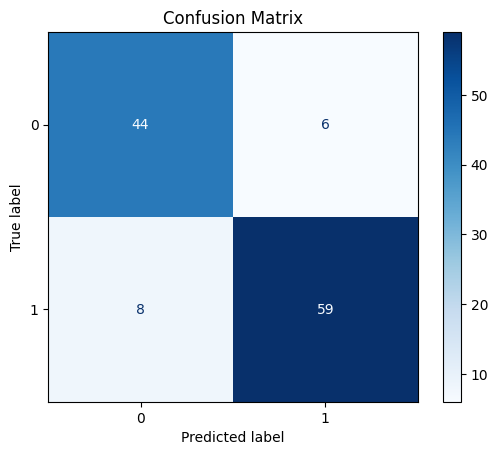

In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### **XGBoost**

> XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

In [ ]:
xgboost_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgboost_model.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.91      0.88      0.89        67

    accuracy                           0.88       117
   macro avg       0.88      0.88      0.88       117
weighted avg       0.88      0.88      0.88       117



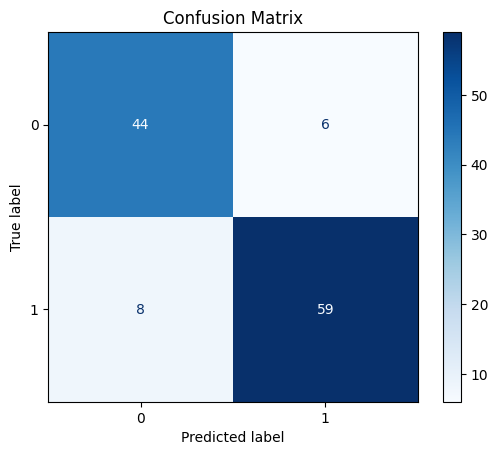

In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

The following models accept raw categorical feature data as input.

#### **LightGBM**

>LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

[LightGBM](https://lightgbm.readthedocs.io/en/latest/)

In [ ]:
lgbmc_model = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=100,
    max_depth=3,
    min_data_in_leaf=3,
    num_leaves=7,
    force_row_wise=True,
    random_state=33
)


lgbmc_model.fit(X_train, y_train, categorical_feature=columns_category.to_list())

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Number of positive: 367, number of negative: 296
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553544 -> initscore=0.215002
[LightGBM] [Info] Start training from score 0.215002


LGBMClassifier(force_row_wise=True, learning_rate=0.05, max_depth=3,
               min_data_in_leaf=3, num_leaves=7, random_state=33)

In [ ]:
y_pred = lgbmc_model.predict(X_val)
print(classification_report(y_pred, y_val))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       0.94      0.90      0.92        68

    accuracy                           0.91       117
   macro avg       0.90      0.91      0.90       117
weighted avg       0.91      0.91      0.91       117



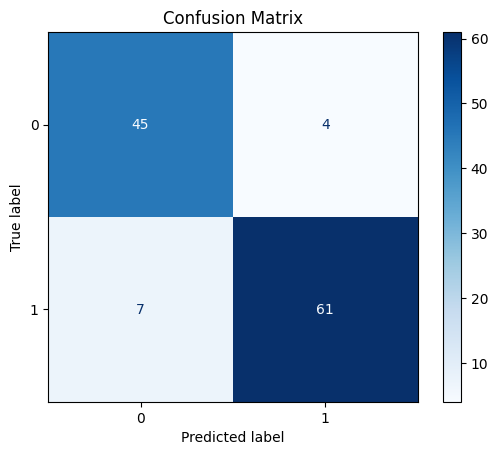

In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

#### **CatBoost**

> CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies, including CERN, Cloudflare, Careem taxi. It is in open-source and can be used by anyone. [CatBoost](https://catboost.ai/)

In [ ]:
cat_boost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, verbose=0)
cat_boost_model.fit(X_train, y_train, cat_features=columns_category.to_list())

In [ ]:
y_pred = cat_boost_model.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        47
           1       0.94      0.87      0.90        70

    accuracy                           0.89       117
   macro avg       0.88      0.89      0.89       117
weighted avg       0.89      0.89      0.89       117



In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### **Stacking**

Stacking is an ensemble learning method that combines multiple base models to improve prediction accuracy. First, several base models are trained on the original data. Their predictions are then used as new features (metadata) to train a meta-model, which learns how to best combine these predictions for the final output. This two-level structure leverages the strengths of diverse models and often achieves better performance than any single model alone

In [ ]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=1)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=2)),
    ('svc', SVC(probability=True))
]

meta_model = LogisticRegression()

In [ ]:
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, passthrough=False)
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=1)),
                               ('gb',
                                GradientBoostingClassifier(n_estimators=50,
                                                           random_state=2)),
                               ('svc', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [ ]:
y_pred = stacking_model.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74        33
           1       0.85      0.78      0.81        50

    accuracy                           0.78        83
   macro avg       0.78      0.78      0.78        83
weighted avg       0.79      0.78      0.78        83



In [ ]:
matrix = confusion_matrix(y_pred, y_val)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

---

## **Summary**

**Bagging**

In [ ]:
y_pred = bagging_clf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        57
           1       0.91      0.85      0.88        81

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.87      0.86      0.86       138



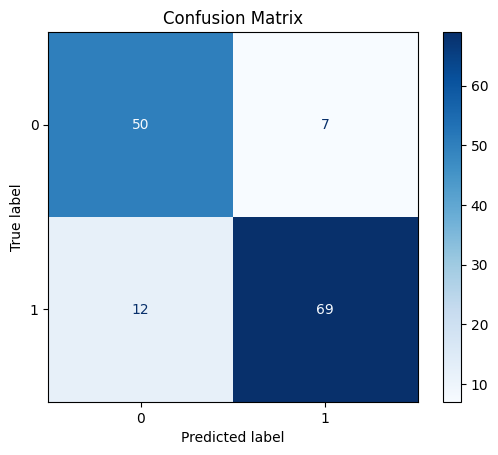

In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**Random Forest**

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        58
           1       0.91      0.86      0.88        80

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



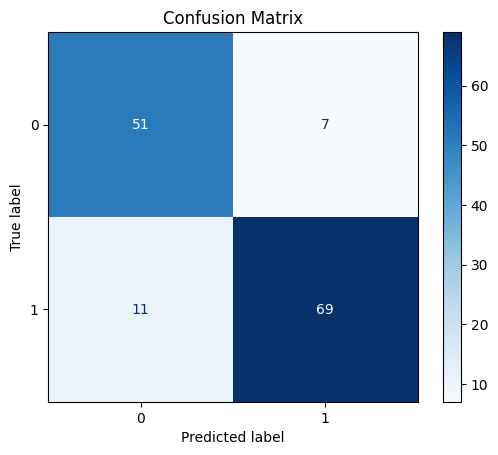

In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**GradientBoostingClassifier**

In [ ]:
y_pred = gradient_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        56
           1       0.93      0.87      0.90        82

    accuracy                           0.88       138
   macro avg       0.88      0.89      0.88       138
weighted avg       0.89      0.88      0.88       138



In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**HistGradientBoostingClassifier**

In [ ]:
y_pred = hist_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        58
           1       0.91      0.86      0.88        80

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



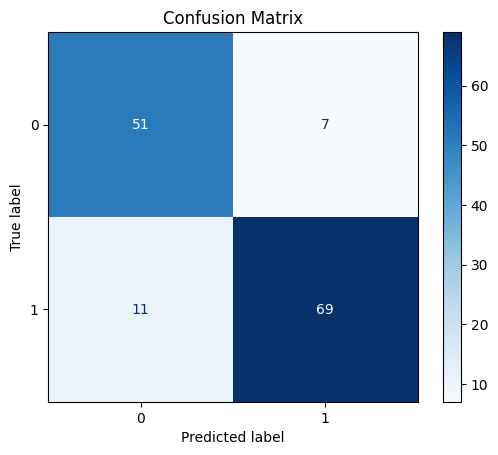

In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**XGBoost**

In [ ]:
y_pred = xgboost_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        58
           1       0.92      0.88      0.90        80

    accuracy                           0.88       138
   macro avg       0.88      0.89      0.88       138
weighted avg       0.89      0.88      0.88       138



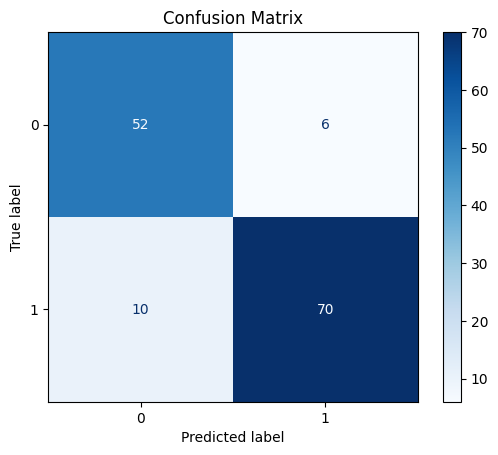

In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**LightGBM**

In [ ]:
y_pred = lgbmc_model.predict(X_test)
print(classification_report(y_pred, y_test))

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        59
           1       0.89      0.86      0.88        79

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**CatBoost**

In [ ]:
y_pred = cat_boost_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82        57
           1       0.89      0.84      0.87        81

    accuracy                           0.85       138
   macro avg       0.84      0.85      0.84       138
weighted avg       0.85      0.85      0.85       138



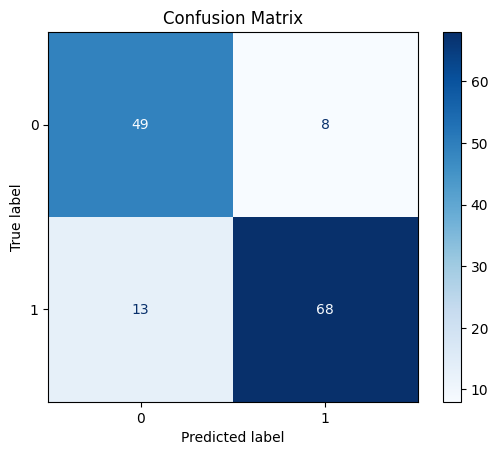

In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**Stacking**

In [ ]:
y_pred = stacking_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        58
           1       0.93      0.89      0.91        80

    accuracy                           0.90       138
   macro avg       0.89      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138



In [ ]:
matrix = confusion_matrix(y_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()